Задача 4.3. Смоделировать с помощью метода Эйлера-Маруямы решение СДУ:

𝑑𝑥𝑡= −(𝜆+𝜇)𝑥𝑡𝑑𝑡+1/𝜀(𝛼−𝛽)𝑥𝑡(1−𝑥𝑡)𝑑𝑤𝑡, 𝑥0 ~ 𝑅[0,1]. (4.20)

При реализации учитывать свойство 𝑃{𝑥𝑡 ∈(0,1)}=1. На отрезке времени [0,10] с шагом дискретизации 0.0001 построить график траектории для значений парамет-ров (𝜆,𝜇,𝜀,𝛼,𝛽)=(0.5,0.2,0.1,2,1). С помощью осреднения по пучку траекторий 1000 построить графики выборочного среднего и дисперсии смоделированного процесса.

In [1]:
import numpy as np
from tqdm import tqdm
from matplotlib.pylab import plt

In [2]:
def a_func(mu, lam, eps, alpha, beta, y, t):
    return -1. * (lam + mu) * y


def b_func(mu, lam, eps, alpha, beta, y, t):
    return ((alpha - beta) / eps) * y * (1 - y)


def dW(h):
    return np.random.normal(loc=0.0, scale=np.sqrt(h))

Случай lam = 0.5, mu = 0.2, eps = 0.1, alpha = 2, beta = 1, T = 10, h = 1e-4, n = 1

In [3]:
lam, mu, eps, alpha, beta, T, h, n = (0.5, 0.2, 0.1, 2, 1, 10, 1e-4, 1)
y_start = np.random.uniform(low=0, high=1, size=1)[0]
T_start = 0

Метод Эйлера-Маруямы: 𝑌𝑚𝑛= 𝑌𝑚−1𝑛+ 𝑎(𝑌𝑚−1𝑛,𝜏𝑚−1𝑛)ℎ+ b(𝑌𝑚−1𝑛,𝜏𝑚−1𝑛) (𝑤(𝜏𝑚𝑛)−𝑤(𝜏𝑚−1𝑛)), 𝑌0𝑛=𝑋0 

In [4]:
def plot_model(lam, mu, eps, alpha, beta, T, h, n, T_start, y_start, a_func, b_func, dW):
    grid = np.arange(T_start, T + h, h) # Сделаем сетку из различных T
    y_mas = np.zeros(grid.shape[0]) # пустой массив размерности сетки
    y_mas[0] = y_start
    for i in tqdm(range(n)):
      for j in range(1, grid.shape[0]):
          t_cur = grid[j - 1]
          y_last = y_mas[j - 1]
          # clip для того, чтобы P (x in (0,1)) = 1
          y_mas[j] = np.clip(y_last + a_func(mu, lam, eps, alpha, beta, y_last, t_cur) * h + b_func(mu, lam, eps, alpha, beta, y_last, t_cur) * dW(h), 0, 1)
      plt.plot(grid, y_mas)

100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


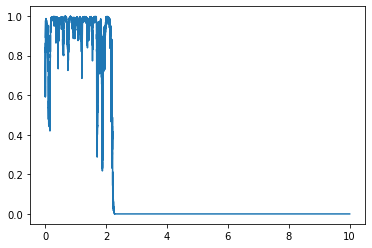

In [17]:
plot_model(lam, mu, eps, alpha, beta, T, h, n, T_start, y_start, a_func, b_func, dW)

теперь 1000 траекторий и считаем среднее и дисперсию

In [16]:
def get_m_and_k(lam, mu, eps, alpha, beta, T, h, n, T_start, y_start, a_func, b_func, dW):
    grid = np.arange(T_start, T + h, h) # Сделаем сетку из различных T
    y_mas = np.zeros(grid.shape[0]) # пустой массив размерности сетки
    m_t = np.zeros(grid.shape[0])
    k_t = np.zeros(grid.shape[0])
    y_mas[0] = y_start
    dw = [dW(h) for i in range(n * grid.shape[0])]
    for i in tqdm(range(n)):
      for j in range(1, grid.shape[0]):
          t_cur = grid[j - 1]
          y_last = y_mas[j - 1]
          #y_mas[j] = np.clip(y_last + a_func(mu, lam, eps, alpha, beta, y_last, t_cur) * h + b_func(mu, lam, eps, alpha, beta, y_last, t_cur) * dW(h), 0, 1)
          y_mas[j] = np.clip(y_last + -1. * (lam + mu) * y_last * h + ((alpha - beta) / eps) * y_last * (1 - y_last) * dw[i*grid.shape[0] + j], 0, 1)
      m_t += y_mas
      k_t += (y_mas ** 2)
      plt.plot(grid, y_mas)
    plt.show()
    return m_t, k_t

100%|██████████| 1000/1000 [33:22<00:00,  2.00s/it]


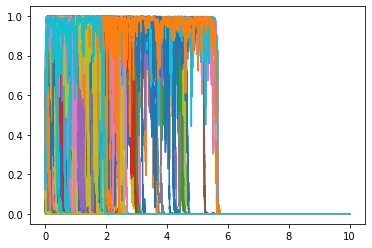

In [24]:
n = 1000
m_t, k_t = get_m_and_k(lam, mu, eps, alpha, beta, T, h, n, T_start, y_start, a_func, b_func, dW)

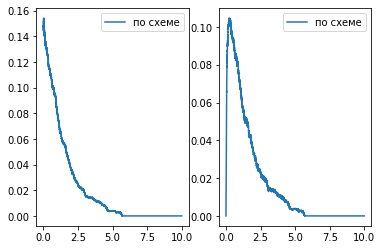

In [25]:
fig, axes = plt.subplots(1, 2)
mean = np.array(m_t) / n
var = np.array(k_t) / n - (mean ** 2)
grid = np.arange(T_start, T + h, h)
axes[0].plot(grid, mean, label='по схеме')
axes[1].plot(grid, var, label='по схеме')
axes[0].legend()
axes[1].legend()

работает медленно, переделаем, чтобы обрабатывать 10000 сразу

In [131]:
lam, mu, eps, alpha, beta, T, h = (0.5, 0.2, 0.1, 2, 1, 10, 1e-4)
n = 10000
T_start = 0
grid = np.arange(T_start, T + h, h)
y = np.random.uniform(size=n)

In [132]:
m_t = [np.mean(y)]
k_t = [np.mean(y**2)]
for i in tqdm(range(1, grid.shape[0])):
  d = np.random.normal(loc = 0.0, scale = 1, size = n)
  y = y - 1. * (lam + mu) * y * h + ((alpha - beta) / eps) * y * (1 - y) * np.sqrt(h) * d
  m_t.append(np.mean(y))
  k_t.append(np.mean(y**2))

100%|██████████| 100000/100000 [00:59<00:00, 1686.88it/s]


In [133]:
m_t = np.array(m_t)
k_t = np.array(k_t)
mean = m_t
var = k_t - m_t**2

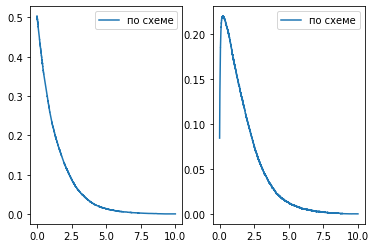

In [134]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(grid, mean, label='по схеме')
axes[1].plot(grid, var, label='по схеме')
axes[0].legend()
axes[1].legend()

Задача 4.4. В условиях задачи 3.5 (см. предыдущую лекцию) смоделировать с помощью метода Эйлера-Маруямы решение СДУ (3.23), в котором F(t) является решением (4.20) с параметрами из задачи 4.3. На отрезке времени [0,10] с шагом дискретизации 0.0001 по-строить график 10 траекторий решения СДУ (3.23) 𝑋(𝑡) и его производных 𝑋′(𝑡) (на от-дельном графике)

In [116]:
def make_with_F(lam, mu, eps, alpha, beta, T, h, n, T_start, y_start, a_func, b_func, dW, c, k, m):
  F = [np.random.uniform(size=n)]
  grid = np.arange(T_start, T + h, h)
  for t in tqdm(grid):
    F.append(F[-1] + -1. * (lam + mu) * F[-1] * h + ((alpha - beta) / eps) * F[-1] * (1 - F[-1]) * dW(h))
  F = np.array(F)
  y = [[0, 0] for i in range(n)]
  for i in range(n):
    for j in range(2, grid.shape[0] - 1):
      y[i].append(((2 - k * h**2 / m) * y[i][-1] + (c * h / 2 - 1) * y[i][-2] + F[j, i] * h**2) / (1 + c * h / 2))
  y = np.array(y)
  for i in range(y.shape[0]):
    plt.plot(np.linspace(0, T, grid.shape[0] - 1), y [i, :])
  plt.show()

100%|██████████| 100001/100001 [00:01<00:00, 75927.94it/s]


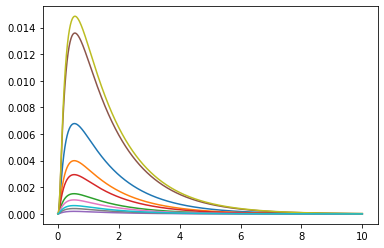

In [117]:
n = 10
c = 5
k = 3
m = 1
make_with_F(lam, mu, eps, alpha, beta, T, h, n, T_start, y_start, a_func, b_func, dW, c, k, m)